In [11]:
import sys
sys.path.append('/home/luis-felipe/brats_lf/src')
sys.path.insert(1, '../src')
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss



import metrics
import get_data as gd
import models_nn 
import train_and_eval as TE
import utils

import warnings
warnings.simplefilter("ignore")

In [12]:
PROJ_ROOT = os.path.join(os.path.abspath(os.pardir))
PROJ_ROOT

'/home/luis-felipe/brats_lf'

In [13]:
class GlobalConfig:
    
    root_dir = os.path.join(PROJ_ROOT,'data')
    train_root_dir =os.path.join(root_dir, 'BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData')
    test_root_dir = os.path.join(root_dir, 'BraTS2020_TrainingData','MICCAI_BraTS2020_ValidationData')
    path_to_csv = os.path.join(root_dir,'train_data.csv')
    pretrained_model_path = os.path.join(PROJ_ROOT,'brats2020logs','unet','last_epoch_model.pth')
    train_logs_path = os.path.join(PROJ_ROOT,'brats2020logs','unet','train_log.csv')
    ae_pretrained_model_path = os.path.join(PROJ_ROOT,'brats2020logs','ae','autoencoder_best_model.pth')
    tab_data = os.path.join(PROJ_ROOT,'brats2020logs','data','df_with_voxel_stats_and_latent_features.csv')
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

In [14]:
sample_filename = os.path.join(PROJ_ROOT,'MICCAI_BraTS2020_TrainingData','BraTS20_Training_001','BraTS20_Training_001_flair.nii.gz')
sample_filename_mask = os.path.join(PROJ_ROOT,'MICCAI_BraTS2020_TrainingData','BraTS20_Training_001','BraTS20_Training_001_seg.nii.gz')

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [15]:
sample_filename2 = os.path.join(PROJ_ROOT,'MICCAI_BraTS2020_TrainingData','BraTS20_Training_001','BraTS20_Training_001_t1.nii.gz')
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = os.path.join(PROJ_ROOT,'MICCAI_BraTS2020_TrainingData','BraTS20_Training_001','BraTS20_Training_001_t2.nii.gz')

sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = os.path.join(PROJ_ROOT,'MICCAI_BraTS2020_TrainingData','BraTS20_Training_001','BraTS20_Training_001_t1ce.nii.gz')
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

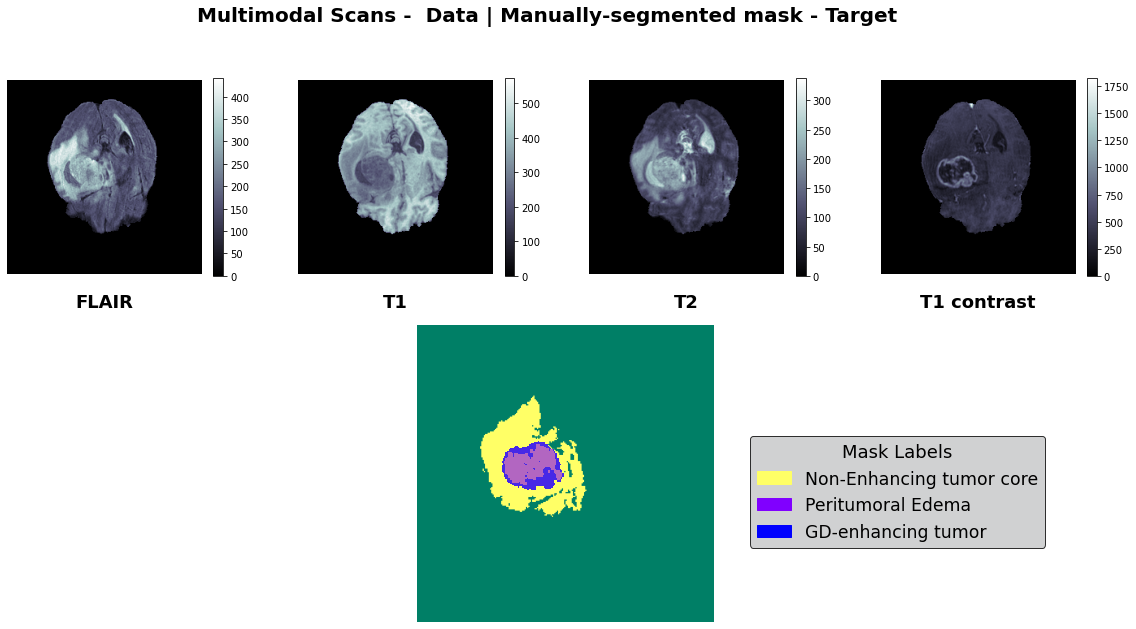

In [16]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [18]:
dataloader = gd.get_dataloader(dataset=gd.BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0)
len(dataloader)

data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 34, in _pin_memory_loop
    data = pin_memory(data)
  File "/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in pin_memory
    return type(data)({k: pin_memory(sample) for k, sample in data.items()})  # type: ignore[call-arg]
  File "/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in <dictcomp>
    return type(data)({k: pin_memory(sample) for k, sample in data.items()})  # type: ignore[call-arg]
  File "/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 50, in pin_memory
    return data.pin_memory()
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.


In [ ]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)